# Practice notebook for confidence intervals using NHANES data

This notebook will give you the opportunity to practice working with confidence intervals using the NHANES data.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

df = pd.read_csv("nhanes_2015_2016.csv")

In [2]:
df.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210'],
      dtype='object')

## Question 1

Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

In [3]:
# encode categorical variables with useful labels
df["RIAGENDRx"] = df.RIAGENDR.replace({1: 'Male', 2: 'Female'})
#  omit people who responded "Don't know" (- and 99) or refused to answer (77)
df["DMDMARTLx"] = df.DMDMARTL.replace({1: "Married", 2: "Widowed", 3: "Divorced", 4: "Separated", 5: "Never married",
                                      6: "Living w/partner"})
df["DMDEDUC2x"] = df.DMDEDUC2.replace({1: "<9", 2: "9-11", 3: "HS/GED", 4: "Some college/AA", 5: "College" 
                                       })
# 7: "Refused", 9: "Don't know"


=======================================================================================================================
###### Working below

In [4]:
# enter your code here
df_females = df[df.RIAGENDRx == "Female"]
df_females_married = df_females[df_females.DMDMARTLx == "Married"]
df_females_not_married = df_females[df_females.DMDMARTLx != "Married"].dropna()


In [5]:
# sanity check for NA values
df_females_married.DMDMARTLx.isna().sum()

0

In [6]:
df_females_not_married.DMDMARTLx.isna().sum()

0

In [7]:
df_females_married.DMDEDUC2x.isna().sum()

0

In [8]:
df_females_not_married.DMDEDUC2x.isna().sum()

0

In [ ]:
# df["DMDEDUC2x2"] = df["DMDEDUC2x"]

In [ ]:
# type(df["DMDEDUC2x2"])

###### Working above
=======================================================================================================================

In [9]:
# Within each of these groups, calculate the proportion of women who have completed college.
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
conditions = [df["DMDEDUC2x"] == "College",
              df["DMDEDUC2x"] != "College"]
outputs = ["Completed college", "Yet to complete college"]
# numpy.org/doc/stable/reference/generated/numpy.select.html
df["DMDEDUC2x2"] = np.select(conditions, outputs)


In [10]:
df["DMDEDUC2x2"].head()

0          Completed college
1    Yet to complete college
2    Yet to complete college
3          Completed college
4    Yet to complete college
Name: DMDEDUC2x2, dtype: object

In [11]:
pd.crosstab(df["DMDEDUC2x2"])

TypeError: crosstab() missing 1 required positional argument: 'columns'

In [12]:
# to repeat the flow above using the original df, so we can have a crosstab of "married vs unmarried" and "completed college vs yet to complete college"
df_college = df
df_college.dropna(subset = ['DMDMARTLx', 'DMDEDUC2x'])

conditions_college = [df_college["DMDEDUC2x"] == "College",
              df_college["DMDEDUC2x"] != "College"]
outputs_college = ["Completed college", "Yet to complete college"]
df_college["DMDEDUC2x2"] = np.select(conditions_college, outputs_college)



conditions_married = [df_college.DMDMARTLx == "Married",
                      df_college.DMDMARTLx != "Married"]
outputs_married = ["Married", "Not Married"]
df_college["DMDMARTLx2"] = np.select(conditions_married, outputs_married)



In [13]:
pd.crosstab(df_college["DMDMARTLx2"], df_college["DMDEDUC2x2"])

DMDEDUC2x2,Completed college,Yet to complete college
DMDMARTLx2,,
Married,827,1953
Not Married,539,2416


In [14]:
df_college_proportion = df_college.groupby(df_college.DMDMARTLx2).agg({"DMDEDUC2x2": [lambda x: np.mean(x=="Completed college"), np.size]})
df_college_proportion.columns = ["Proportion", "Total_n"] # The default column names are unclear, so we replace them here
df_college_proportion


,Proportion,Total_n
DMDMARTLx2,,
Married,0.297482,2780
Not Married,0.182403,2955


In [15]:
# Retrieve Proportion and 'n'/sample size in each category
p_married_college = df_college_proportion.Proportion[0]
p_not_married_college = df_college_proportion.Proportion[1]
n_married_college = df_college_proportion.Total_n[0]
n_not_married_college = df_college_proportion.Total_n[1]

# Calculate Standard Error
# recall proportion's se = np.sqrt(p * (1 - p) / n)
se_married_college = np.sqrt(p_married_college * (1 - p_married_college) / n_married_college)
se_not_married_college = np.sqrt(p_not_married_college * (1 - p_not_married_college) / n_not_married_college)

# construct 95% confidence intervals for each of these proportions
print("95% CI for married females who completed college : (", p_married_college - 1.96 * se_married_college, "," , p_married_college + 1.96 * se_married_college, "), with a spread of", se_married_college*2)
print("95% CI for unmarried females who completed college : (", p_not_married_college - 1.96 * se_not_married_college, "," , p_not_married_college + 1.96 * se_not_married_college, "), with a spread of", se_not_married_college*2)


95% CI for married females who completed college : ( 0.28048812630097975 , 0.31447590247599866 ), with a spread of 0.017340702130111695
95% CI for unmarried females who completed college : ( 0.16847874970917187 , 0.19632666484243555 ), with a spread of 0.014208119965950844


__Q1a.__ Identify which of the two confidence intervals is wider, and explain why this is the case. 

__Q1b.__ Write 1-2 sentences summarizing these findings for an audience that does not know what a confidence interval is (the goal here is to report the substance of what you learned about how marital status and educational attainment are related, not to teach a person what a confidence interval is).

## Question 2

Construct a 95% confidence interval for the proportion of smokers who are female. Construct a 95% confidence interval for the proportion of smokers who are male. Construct a 95% confidence interval for the **difference** between those two gender proportions.

In [16]:
df.SMQ020.unique()

array([1, 2, 7, 9])

In [17]:
# wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm
# SMQ020 - Smoked at least 100 cigarettes in life - 1 Yes, 2 No
df["SMQ020x"] = df.SMQ020.replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})
df_smoke = df
df_smoke.dropna(subset = ['SMQ020x'])

# enter your code here
df_smoke_proportion = df_smoke.groupby(df.RIAGENDRx).agg({"SMQ020x": [lambda x: np.mean(x==1), np.size]})
df_smoke_proportion.columns = ['Proportion', 'Total_n']
df_smoke_proportion


,Proportion,Total_n
RIAGENDRx,,
Female,0.304435,2976.0
Male,0.512142,2759.0


In [18]:
# retrieve proportion and 'n'/sample size for males and females
p_male_smoke = df_smoke_proportion.Proportion[0]
p_female_smoke = df_smoke_proportion.Proportion[1]
n_male = df_smoke_proportion.Total_n[0]
n_female = df_smoke_proportion.Total_n[1]

# find the SE for male and female smokers
# proportion's se = np.sqrt(p*(1-p)/n)
se_male_smoke = np.sqrt(p_male_smoke * (1 - p_male_smoke) / n_male)
se_female_smoke = np.sqrt(p_female_smoke * (1 - p_female_smoke) / n_female)

# construct 95% CI for male and female smokers
# ll=lower limit, ul=upper limit
ll_male_smoke = p_male_smoke - 1.96 * se_male_smoke
ul_male_smoke = p_male_smoke + 1.96 * se_male_smoke
ll_female_smoke = p_female_smoke - 1.96 * se_female_smoke
ul_female_smoke = p_female_smoke + 1.96 * se_female_smoke
print("95% CI for male smokers : (", ll_male_smoke, "," , ul_male_smoke, "), with a spread of", se_male_smoke*2)
print("95% CI for female smokers : (", ll_female_smoke, "," , ul_female_smoke, "), with a spread of", se_female_smoke*2)


95% CI for male smokers : ( 0.2879023206749516 , 0.3209686470669839 ), with a spread of 0.016870574689812425
95% CI for female smokers : ( 0.4934902211293819 , 0.5307939397984904 ), with a spread of 0.01903250952505535


In [19]:
# difference in proportions
p_diff_smoke = p_male_smoke - p_female_smoke
se_diff_smoke = np.sqrt(se_male_smoke**2 + se_female_smoke**2)
ll_diff_smoke = p_diff_smoke - 1.96 * se_diff_smoke
ul_diff_smoke = p_diff_smoke + 1.96 * se_diff_smoke
print("95% CI for difference between male and females smokers : (", ll_diff_smoke, "," , ul_diff_smoke, "), with a spread of", se_diff_smoke*2)


95% CI for difference between male and females smokers : ( -0.2326312298280253 , -0.18278196335791153 ), with a spread of 0.025433299219445798


__Q2a.__ Why might it be relevant to report the separate gender proportions **and** the difference between the gender proportions?

__Q2b.__ How does the **width** of the confidence interval for the difference between the gender proportions compare to the widths of the confidence intervals for the separate gender proportions?

## Question 3

Construct a 95% interval for height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) in centimeters.  Then convert height from centimeters to inches by dividing by 2.54, and construct a 95% confidence interval for height in inches.  Finally, convert the endpoints (the lower and upper confidence limits) of the confidence interval from inches to back to centimeters   

In [20]:
# enter your code here
df["BMXHTINCH"] = df.BMXHT / 2.54
# https://stackoverflow.com/questions/19124148/modify-output-from-python-pandas-describe
df["BMXHTINCH"].describe()[["mean", "std", "count"]]


mean       65.410565
std         3.968214
count    5673.000000
Name: BMXHTINCH, dtype: float64

In [21]:
height_inch_stats = df["BMXHTINCH"].describe()[["mean", "std", "count"]]
mean_ht_inch = height_inch_stats[0]
sd_ht_inch = height_inch_stats[1]
n = height_inch_stats[2]
se_ht_inch = sd_ht_inch/np.sqrt(n)

ll_ht_inch = mean_ht_inch - 1.96*se_ht_inch
ul_ht_inch = mean_ht_inch + 1.96*se_ht_inch
print("95% CI for height in inches : (", ll_ht_inch, "," , ul_ht_inch, "), with a spread of", se_ht_inch*2)


95% CI for height in inches : ( 65.30730174768685 , 65.51382776342463 ), with a spread of 0.10537041619274658


In [22]:
height_cm_stats = df["BMXHT"].describe()[["mean", "std", "count"]]
mean_ht_cm = height_cm_stats[0]
sd_ht_cm = height_cm_stats[1]
n = height_cm_stats[2]
se_ht_cm = sd_ht_cm/np.sqrt(n)

ll_ht_cm = mean_ht_cm - 1.96*se_ht_cm
ul_ht_cm = mean_ht_cm + 1.96*se_ht_cm
print("95% CI for height in cm : (", ll_ht_cm, "," , ul_ht_cm, "), with a spread of", se_ht_cm*2)


95% CI for height in cm : ( 165.8805464391246 , 166.4051225190986 ), with a spread of 0.2676408571295763


In [23]:
print("Lower limit of height is scaled by this amount when we go from 'inch' to 'cm' :", ll_ht_cm/ll_ht_inch)
print("Upper limit of height is scaled by this amount when we go from 'inch' to 'cm' :", ul_ht_cm/ul_ht_inch)
print("Spread of height is scaled by this amount when we go from 'inch' to 'cm' :", sd_ht_cm/sd_ht_inch)


Lower limit of height is scaled by this amount when we go from 'inch' to 'cm' : 2.54
Upper limit of height is scaled by this amount when we go from 'inch' to 'cm' : 2.5400000000000005
Spread of height is scaled by this amount when we go from 'inch' to 'cm' : 2.54


__Q3a.__ Describe how the confidence interval constructed in centimeters relates to the confidence interval constructed in inches.

## Question 4

Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean BMI for females and for males within each age band.

In [26]:
# enter your code here
df["agegrp"] = pd.cut(df.RIDAGEYR, [18, 28, 38, 48, 58, 68, 78, 88])
df_bmi = df.groupby(["RIAGENDRx", "agegrp"]).agg({"BMXBMI": [np.mean, np.std, np.size]})
df_bmi["BMXBMI", "Lower Limit"] = df_bmi["BMXBMI", "mean"] - (1.96 * df_bmi["BMXBMI", "std"]/np.sqrt(df_bmi["BMXBMI", "size"]))
df_bmi["BMXBMI", "Upper Limit"] = df_bmi["BMXBMI", "mean"] + (1.96 * df_bmi["BMXBMI", "std"]/np.sqrt(df_bmi["BMXBMI", "size"]))
df_bmi.columns = ["Mean", "SD", "Total_n", "Lower Limit", "Upper Limit"]
df_bmi

Mean        SD  Total_n  Lower Limit  Upper Limit
RIAGENDRx agegrp                                                          
Female    (18, 28]  28.019433  8.048854    498.0    27.312505    28.726362
          (28, 38]  29.943443  7.959097    494.0    29.241573    30.645312
          (38, 48]  31.003733  8.044642    514.0    30.308258    31.699207
          (48, 58]  30.787361  7.647590    454.0    30.083880    31.490843
          (58, 68]  31.054664  7.779502    466.0    30.348322    31.761006
          (68, 78]  30.537818  6.780588    279.0    29.742170    31.333467
          (78, 88]  27.850000  5.483781    201.0    27.091880    28.608120
Male      (18, 28]  27.058186  6.679515    458.0    26.446444    27.669928
          (28, 38]  29.697180  6.726690    467.0    29.087083    30.307277
          (38, 48]  29.514646  6.104950    398.0    28.914860    30.114433
          (48, 58]  29.385132  6.151534    419.0    28.796109    29.974155
          (58, 68]  29.232462  5.959024    470.0    28.693718    29.771206
          (68, 78]  28.720270  5.336652    307.0    28.123296    29.317245
          (78, 88]  27.464368  4.695650    177.0    26.772592    28.156143

In [28]:
# df_male_bmi = df[df.RIAGENDRx == "Male"].groupby(["RIAGENDRx", "agegrp"]).agg({"BMXBMI": [np.mean, np.std, np.size]})
df_male_bmi = df[df.RIAGENDRx == "Male"].groupby(["agegrp"]).agg({"BMXBMI": [np.mean, np.std, np.size]})
df_male_bmi["BMXBMI", "Lower Limit"] = df_male_bmi["BMXBMI", "mean"] - (1.96 * df_male_bmi["BMXBMI", "std"]/np.sqrt(df_male_bmi["BMXBMI", "size"]))
df_male_bmi["BMXBMI", "Upper Limit"] = df_male_bmi["BMXBMI", "mean"] + (1.96 * df_male_bmi["BMXBMI", "std"]/np.sqrt(df_male_bmi["BMXBMI", "size"]))
df_male_bmi.columns = ["Mean", "SD", "Total_n", "Lower Limit", "Upper Limit"]
df_male_bmi

,Mean,SD,Total_n,Lower Limit,Upper Limit
agegrp,,,,,
"(18, 28]",27.058186,6.679515,458.0,26.446444,27.669928
"(28, 38]",29.697180,6.726690,467.0,29.087083,30.307277
"(38, 48]",29.514646,6.104950,398.0,28.914860,30.114433
"(48, 58]",29.385132,6.151534,419.0,28.796109,29.974155
"(58, 68]",29.232462,5.959024,470.0,28.693718,29.771206
"(68, 78]",28.720270,5.336652,307.0,28.123296,29.317245
"(78, 88]",27.464368,4.695650,177.0,26.772592,28.156143


In [29]:
# df_female_bmi = df[df.RIAGENDRx == "Female"].groupby(["RIAGENDRx", "agegrp"]).agg({"BMXBMI": [np.mean, np.std, np.size]})
df_female_bmi = df[df.RIAGENDRx == "Female"].groupby(["agegrp"]).agg({"BMXBMI": [np.mean, np.std, np.size]})
df_female_bmi["BMXBMI", "Lower Limit"] = df_female_bmi["BMXBMI", "mean"] - (1.96 * df_female_bmi["BMXBMI", "std"]/np.sqrt(df_female_bmi["BMXBMI", "size"]))
df_female_bmi["BMXBMI", "Upper Limit"] = df_female_bmi["BMXBMI", "mean"] + (1.96 * df_female_bmi["BMXBMI", "std"]/np.sqrt(df_female_bmi["BMXBMI", "size"]))
df_female_bmi.columns = ["Mean", "SD", "Total_n", "Lower Limit", "Upper Limit"]
df_female_bmi

,Mean,SD,Total_n,Lower Limit,Upper Limit
agegrp,,,,,
"(18, 28]",28.019433,8.048854,498.0,27.312505,28.726362
"(28, 38]",29.943443,7.959097,494.0,29.241573,30.645312
"(38, 48]",31.003733,8.044642,514.0,30.308258,31.699207
"(48, 58]",30.787361,7.647590,454.0,30.083880,31.490843
"(58, 68]",31.054664,7.779502,466.0,30.348322,31.761006
"(68, 78]",30.537818,6.780588,279.0,29.742170,31.333467
"(78, 88]",27.850000,5.483781,201.0,27.091880,28.608120


In [30]:
# after fixing by removing the 1st-level grouping on 'Gender'
# we no longer have NaNs when subtracting the 2 cols in a df
df_male_bmi.Mean - df_female_bmi.Mean

agegrp
(18, 28]   -0.961247
(28, 38]   -0.246263
(38, 48]   -1.489086
(48, 58]   -1.402230
(58, 68]   -1.822202
(68, 78]   -1.817548
(78, 88]   -0.385632
Name: Mean, dtype: float64

In [31]:
# https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it
# after getting difference, accumulate data in a list
# then create new df from the list: df_diff_bmi
list_diff_bmi_mean = []
series_diff_bmi_mean = df_male_bmi.Mean - df_female_bmi.Mean
list_diff_bmi_mean = series_diff_bmi_mean.values.tolist()
df_diff_bmi_mean = pd.DataFrame(list_diff_bmi_mean, columns = ["Mean"])

# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
# df_diff_bmi_mean.reindex()
# https://stackoverflow.com/questions/18176933/create-an-empty-data-frame-with-index-from-another-data-frame
df_diff_bmi_mean.index = df_male_bmi.index
df_diff_bmi_mean

,Mean
agegrp,
"(18, 28]",-0.961247
"(28, 38]",-0.246263
"(38, 48]",-1.489086
"(48, 58]",-1.402230
"(58, 68]",-1.822202
"(68, 78]",-1.817548
"(78, 88]",-0.385632


In [32]:
# Get the SE for the difference in means
# http://vassarstats.net/dist2.html : np.sqrt(sdmales**2 / nmales + sdfemales**2 / nfemales)

# extract the within-gender SD and n in arrays
male_bmi_sd = df_male_bmi.SD
male_bmi_n = df_male_bmi.Total_n
female_bmi_sd = df_female_bmi.SD
female_bmi_n = df_female_bmi.Total_n

# initialise empty lists
list_male_bmi_sd = []
list_male_bmi_n = []
list_female_bmi_sd = []
list_female_bmi_n = []

# extract within-gender SD and n in lists
list_male_bmi_sd = male_bmi_sd.values.tolist()
list_male_bmi_n = male_bmi_n.values.tolist()
list_female_bmi_sd = female_bmi_sd.values.tolist()
list_female_bmi_n = female_bmi_n.values.tolist()
# list_bmi_cols = list(list_diff_bmi_mean)
# list_bmi_cols.append(list_male_bmi_sd)
# list_bmi_cols.append(list_male_bmi_n)
# list_bmi_cols.append(list_female_bmi_sd)
# list_bmi_cols.append(list_female_bmi_n)

# https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/
# Create pandas dataframe from lists using zip
list_bmi_cols = list(zip(list_diff_bmi_mean, list_male_bmi_sd, list_male_bmi_n, list_female_bmi_sd, list_female_bmi_n))

# recreate the df with 'Mean' from earlier
df_diff_bmi_mean = pd.DataFrame(list_bmi_cols, columns = ["Mean", "Male SD", "Male Count", "Female SD", "Female Count"])
df_diff_bmi_mean.index = df_male_bmi.index
df_diff_bmi_mean

,Mean,Male SD,Male Count,Female SD,Female Count
agegrp,,,,,
"(18, 28]",-0.961247,6.679515,458.0,8.048854,498.0
"(28, 38]",-0.246263,6.726690,467.0,7.959097,494.0
"(38, 48]",-1.489086,6.104950,398.0,8.044642,514.0
"(48, 58]",-1.402230,6.151534,419.0,7.647590,454.0
"(58, 68]",-1.822202,5.959024,470.0,7.779502,466.0
"(68, 78]",-1.817548,5.336652,307.0,6.780588,279.0
"(78, 88]",-0.385632,4.695650,177.0,5.483781,201.0


In [33]:
# Now, calculate the SE for the difference in means
df_diff_bmi_mean["Diff in means SE"] = np.sqrt((df_diff_bmi_mean["Male SD"]**2 / df_diff_bmi_mean["Male Count"]) + (df_diff_bmi_mean["Female SD"]**2 / df_diff_bmi_mean["Female Count"]))

# Construct 95% CI
df_diff_bmi_mean["Diff in means LL"] = df_diff_bmi_mean["Mean"] - 1.96*df_diff_bmi_mean["Diff in means SE"]
df_diff_bmi_mean["Diff in means UL"] = df_diff_bmi_mean["Mean"] + 1.96*df_diff_bmi_mean["Diff in means SE"]
df_diff_bmi_mean


,Mean,Male SD,Male Count,Female SD,Female Count,Diff in means SE,Diff in means LL,Diff in means UL
agegrp,,,,,,,,
"(18, 28]",-0.961247,6.679515,458.0,8.048854,498.0,0.476973,-1.896114,-0.026381
"(28, 38]",-0.246263,6.726690,467.0,7.959097,494.0,0.474473,-1.176230,0.683705
"(38, 48]",-1.489086,6.104950,398.0,8.044642,514.0,0.468563,-2.407470,-0.570703
"(48, 58]",-1.402230,6.151534,419.0,7.647590,454.0,0.468120,-2.319745,-0.484714
"(58, 68]",-1.822202,5.959024,470.0,7.779502,466.0,0.453239,-2.710551,-0.933853
"(68, 78]",-1.817548,5.336652,307.0,6.780588,279.0,0.507502,-2.812252,-0.822844
"(78, 88]",-0.385632,4.695650,177.0,5.483781,201.0,0.523624,-1.411936,0.640672


__Q4a.__ How do the widths of these confidence intervals differ?  Provide an explanation for any substantial diferences in the confidence interval widths that you see.

In [29]:
# type(df_male_bmi.Mean)

pandas.core.series.Series

In [33]:
# df_male_bmi_mean = df_male_bmi.Mean
# df_female_bmi_mean = df_female_bmi.Mean

In [53]:
# df_male_bmi_mean

[27.058185840708003,
 29.697180043383963,
 29.51464646464647,
 29.385131894484417,
 29.232461873638325,
 28.720270270270255,
 27.46436781609195]

In [37]:
# https://stackoverflow.com/questions/39169923/pandas-all-nans-when-subtracting-two-dataframes
# having some issue when subtracting the mean values across each age group because the 'Gender' indexes on the left are different
# so the resulting values are NaN
# df_male_bmi_mean.sub(df_female_bmi_mean.squeeze())


RIAGENDRx  agegrp  
Female     (18, 28]   NaN
           (28, 38]   NaN
           (38, 48]   NaN
           (48, 58]   NaN
           (58, 68]   NaN
           (68, 78]   NaN
           (78, 88]   NaN
Male       (18, 28]   NaN
           (28, 38]   NaN
           (38, 48]   NaN
           (48, 58]   NaN
           (58, 68]   NaN
           (68, 78]   NaN
           (78, 88]   NaN
Name: Mean, dtype: float64

In [44]:
# let us work around the NaN issue by extracting the col values in list format
# then later turn the col values into an array
# https://www.dataindependent.com/pandas/dataframe-to-list/
# list_male_bmi_mean = df_male_bmi.Mean.values.tolist()
# list_male_bmi_mean

[27.058185840708003,
 29.697180043383963,
 29.51464646464647,
 29.385131894484417,
 29.232461873638325,
 28.720270270270255,
 27.46436781609195]

In [45]:
# list_female_bmi_mean = df_female_bmi.Mean.values.tolist()
# list_female_bmi_mean

[28.019433198380565,
 29.943442622950815,
 31.003732809430268,
 30.78736141906873,
 31.054663774403497,
 30.537818181818174,
 27.850000000000037]

In [47]:
# # https://www.educative.io/edpresso/how-to-convert-a-list-to-an-array-in-python
# arr_male_bmi_mean = np.array(df_male_bmi_mean)
# arr_female_bmi_mean = np.array(df_female_bmi_mean)
# arr_male_bmi_mean

array([27.05818584, 29.69718004, 29.51464646, 29.38513189, 29.23246187,
       28.72027027, 27.46436782])

In [50]:
# arr_diff_bmi_mean = arr_male_bmi_mean-arr_female_bmi_mean
# print("Difference in mean BMI between males and females across age groups", arr_diff_bmi_mean)

Difference in mean BMI between males and females across age groups [-0.96124736 -0.24626258 -1.48908634 -1.40222952 -1.8222019  -1.81754791
 -0.38563218]


## Question 5

Construct a 95% confidence interval for the first and second systolic blood pressure measures, and for the difference between the first and second systolic blood pressure measurements within a subject.

In [34]:
# enter code here
# https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY1
# 'BPXSY1', 'BPXDI1', 'BPXSY2','BPXDI2'

# AttributeError: module 'statsmodels.stats.api' has no attribute 'weightstats'
# sm.stats.weightstats.zconfint
# sm.stats.zconfint(df["BPXSY1"], df["BPXSY2"])
# (nan, nan)

df_systolic = df[["BPXSY1", "BPXSY2"]].agg({"BPXSY1" : [np.mean, np.std, 'count'], 
                               "BPXSY2" : [np.mean, np.std, 'count']}) 
df_systolic

,BPXSY1,BPXSY2
mean,125.084614,124.783017
std,18.480873,18.527012
count,5401.000000,5535.000000


In [35]:
df_systolic = df_systolic.T
df_systolic.columns = ['average', 'sd', 'n']

# before we updated the col names, the col names were: mean std count
# error: unsupported operand type(s) for *: 'float' and 'method'
# df_systolic["lower_limit"] = df_systolic.mean - 1.96 * df_systolic.std
# df_systolic["upper_limit"] = df_systolic.mean + 1.96 * df_systolic.std

df_systolic["se"] = df_systolic.sd/np.sqrt(df_systolic.n)
df_systolic["lower_limit"] = df_systolic.average - 1.96 * df_systolic.se
df_systolic["upper_limit"] = df_systolic.average + 1.96 * df_systolic.se


df_systolic

,average,sd,n,se,lower_limit,upper_limit
BPXSY1,125.084614,18.480873,5401.0,0.251470,124.591734,125.577494
BPXSY2,124.783017,18.527012,5535.0,0.249027,124.294924,125.271110


In [36]:
# difference in mean systolic BP within the same individual
df["diff_systolic"] = df.BPXSY1 - df.BPXSY2
df["diff_systolic"].describe()


count    5369.000000
mean        0.674986
std         5.046465
min       -26.000000
25%        -2.000000
50%         0.000000
75%         4.000000
max        32.000000
Name: diff_systolic, dtype: float64

In [37]:
diff_systolic_mean = df["diff_systolic"].describe()[1]
diff_systolic_std = df["diff_systolic"].describe()[2]

diff_systolic_se = np.sqrt(df_systolic.se[0]**2 /df_systolic.n[0] + df_systolic.se[1]**2 /df_systolic.n[1])
diff_systolic_ll = diff_systolic_mean - 1.96*diff_systolic_se
diff_systolic_ul = diff_systolic_mean + 1.96*diff_systolic_se
print("Mean difference in systolic BP within the same individual is :", diff_systolic_mean, "with a 95% CI of (", diff_systolic_ll, ",", diff_systolic_ul, ")", "and a standard error of", diff_systolic_se)


Mean difference in systolic BP within the same individual is : 0.6749860309182343 with a 95% CI of ( 0.6656041113496257 , 0.6843679504868428 ) and a standard error of 0.0047866936574533555


__Q5a.__ Based on these confidence intervals, would you say that a difference of zero between the population mean values of the first and second systolic blood pressure measures is consistent with the data?

__Q5b.__ Discuss how the width of the confidence interval for the within-subject difference compares to the widths of the confidence intervals for the first and second measures.

## Question 6

Construct a 95% confidence interval for the mean difference between the average age of a smoker, and the average age of a non-smoker.

In [38]:
# insert your code here
# split into 2 dataframes - 1 for smokers, 1 for nonsmokers
df_smk = df[df["SMQ020x"] == 1]
df_no_smk = df[df["SMQ020x"] == 0]

age_smk_n = df_smk.RIDAGEYR.describe()[0]
age_nosmk_n = df_no_smk.RIDAGEYR.describe()[0]
age_smk_mean = df_smk.RIDAGEYR.describe()[1]
age_nosmk_mean = df_no_smk.RIDAGEYR.describe()[1]
age_smk_std = df_smk.RIDAGEYR.describe()[2]
age_nosmk_std = df_no_smk.RIDAGEYR.describe()[2]

age_smk_se = age_smk_std/np.sqrt(age_smk_n)
age_nosmk_se = age_nosmk_std/np.sqrt(age_nosmk_n)
print("Mean age of smokers is :", age_smk_mean, "with a 95% CI of (", age_smk_mean-1.96*age_smk_se, ",", age_smk_mean+1.96*age_smk_se, ")", "and a standard error of", age_smk_se)
print("Mean age of non-smokers is :", age_nosmk_mean, "with a 95% CI of (", age_nosmk_mean-1.96*age_nosmk_se, ",", age_nosmk_mean+1.96*age_nosmk_se, ")", "and a standard error of", age_nosmk_se)


age_smk_ll = age_smk_mean-1.96*age_smk_se
age_smk_ul = age_smk_mean+1.96*age_smk_se
age_nosmk_ll = age_nosmk_mean-1.96*age_nosmk_se
age_nosmk_ul = age_nosmk_mean+1.96*age_nosmk_se

Mean age of smokers is : 52.09659335920655 with a 95% CI of ( 51.38590645243244 , 52.807280265980665 ) and a standard error of 0.3625953605990387
Mean age of non-smokers is : 45.259835584263065 with a 95% CI of ( 44.637075954817284 , 45.882595213708846 ) and a standard error of 0.31773450481927484


In [80]:
# difference in mean age between smokers and non-smokers
age_diff_mean = age_smk_mean - age_nosmk_mean

# Get the SE for the difference in means
# http://vassarstats.net/dist2.html : np.sqrt(sdmales**2 / nmales + sdfemales**2 / nfemales)
age_diff_se = np.sqrt(age_smk_se**2 / age_smk_n + age_nosmk_se**2 / age_nosmk_n)
age_diff_ll = age_diff_mean - 1.96*age_diff_se
age_diff_ul = age_diff_mean + 1.96*age_diff_se
print("Mean difference in age between smokers and non-smokers is :", age_diff_mean, "with a 95% CI of (", age_diff_ll, ",", age_diff_ul, ")", "and a standard error of", age_diff_se)


Mean difference in age between smokers and non-smokers is : 6.836757774943486 with a 95% CI of ( 6.818546087080718 , 6.854969462806253 ) and a standard error of 0.009291677481003792


In [40]:
print("Min age :", df.RIDAGEYR.min())
print("Max age :", df.RIDAGEYR.max())

Min age : 18
Max age : 80


__Q6a.__ Use graphical and numerical techniques to compare the variation in the ages of smokers to the variation in the ages of non-smokers.  

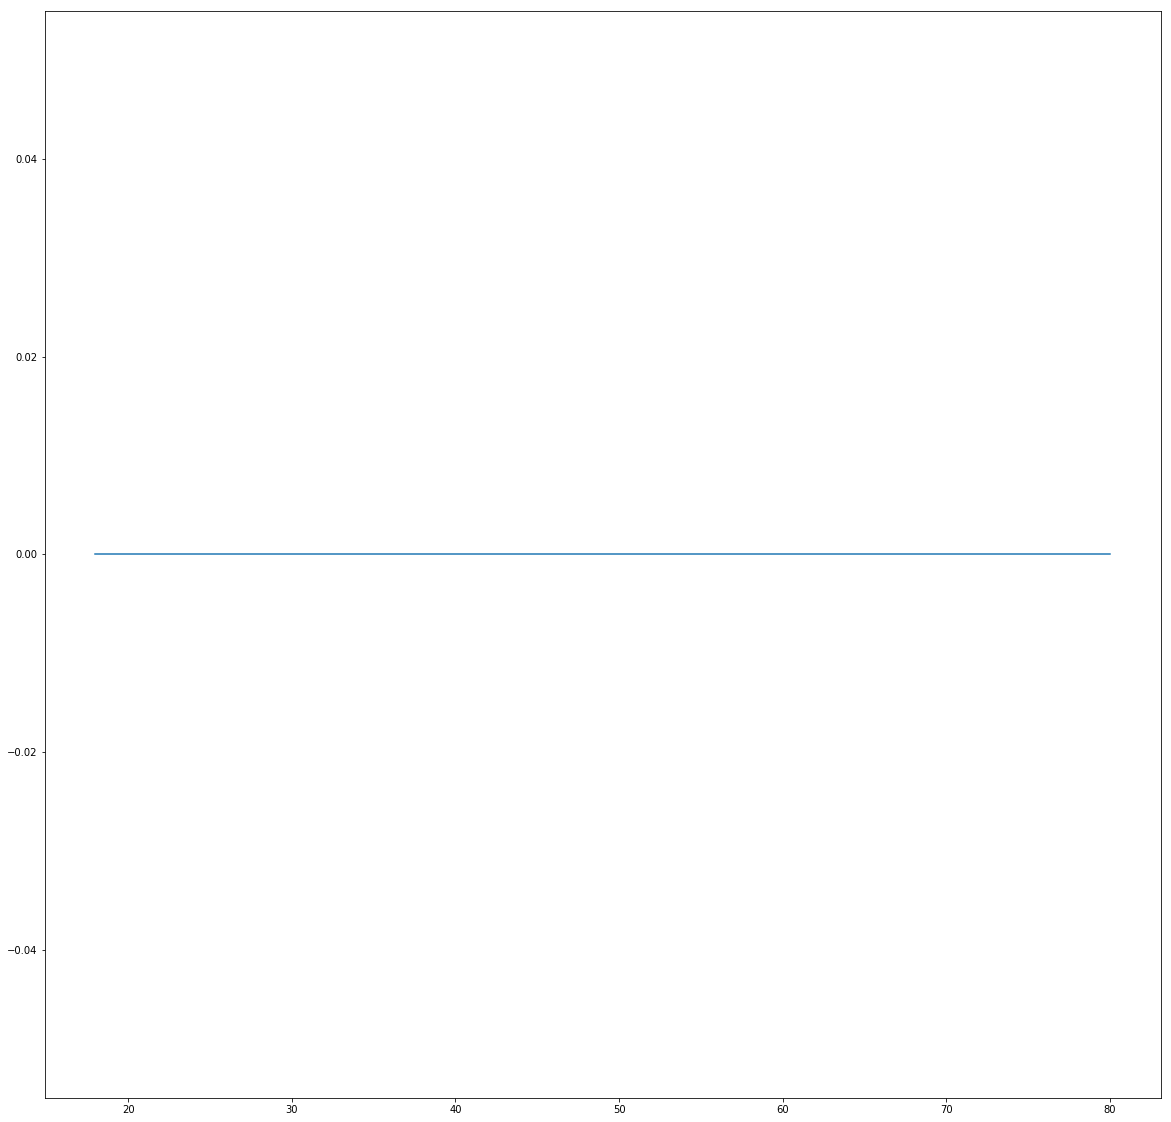

In [81]:
# https://stackoverflow.com/questions/10138085/how-to-plot-normal-distribution
ages = range(18, 81)
plt.plot(ages, stats.norm.pdf(ages, age_diff_mean, age_diff_se))


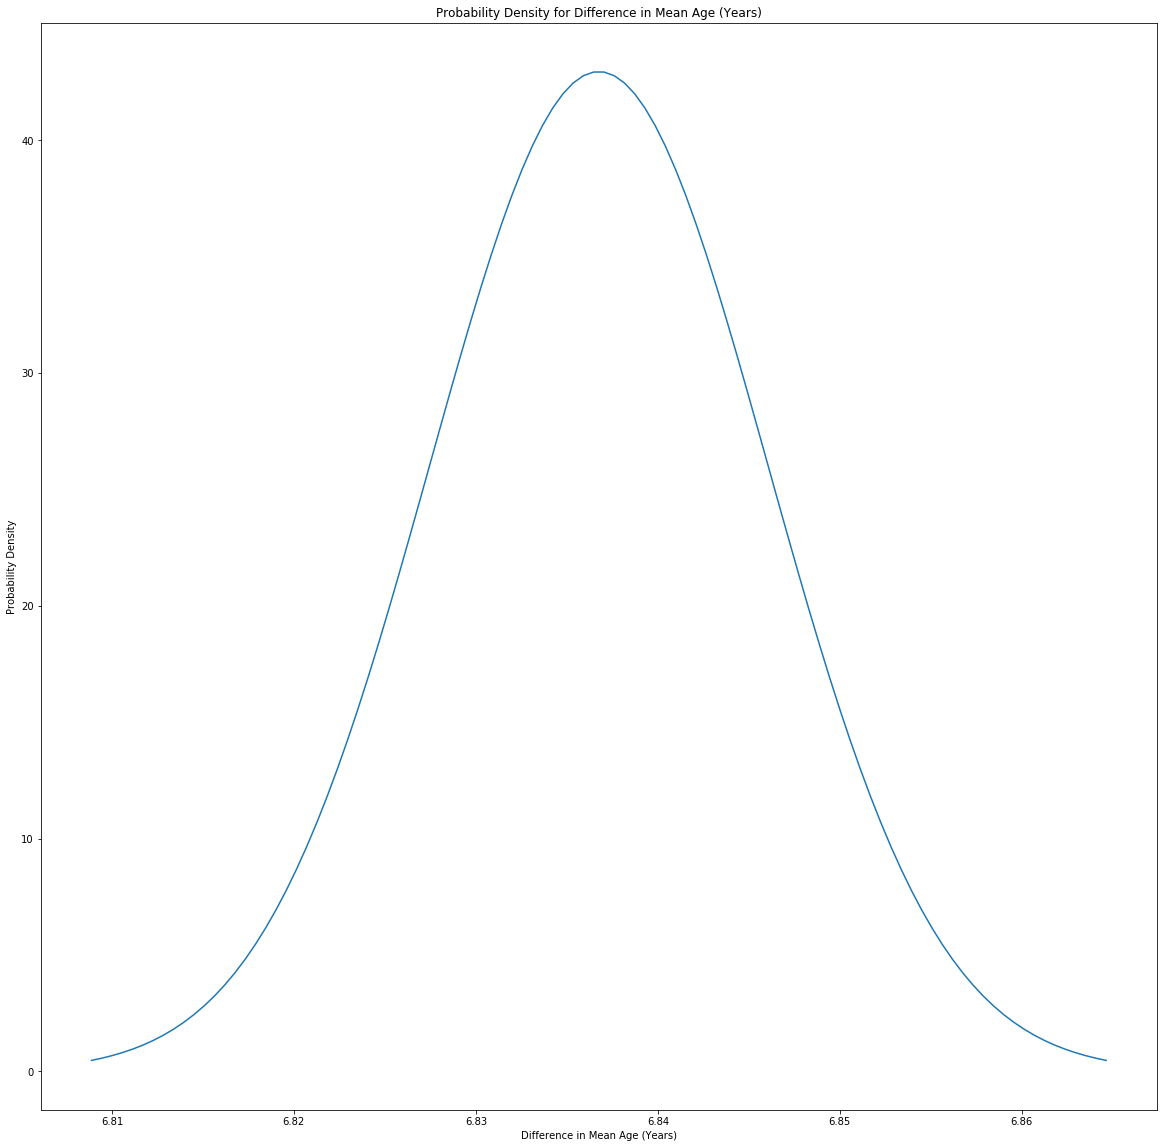

In [82]:
# variation in difference between mean age of smokers and non-smokers
x = np.linspace(age_diff_mean - 3*age_diff_se, age_diff_mean + 3*age_diff_se, 100)
plt.plot(x, stats.norm.pdf(x, age_diff_mean, age_diff_se))
plt.xlabel("Difference in Mean Age (Years)")
plt.ylabel("Probability Density")
plt.title("Probability Density for Difference in Mean Age (Years)")
plt.show()

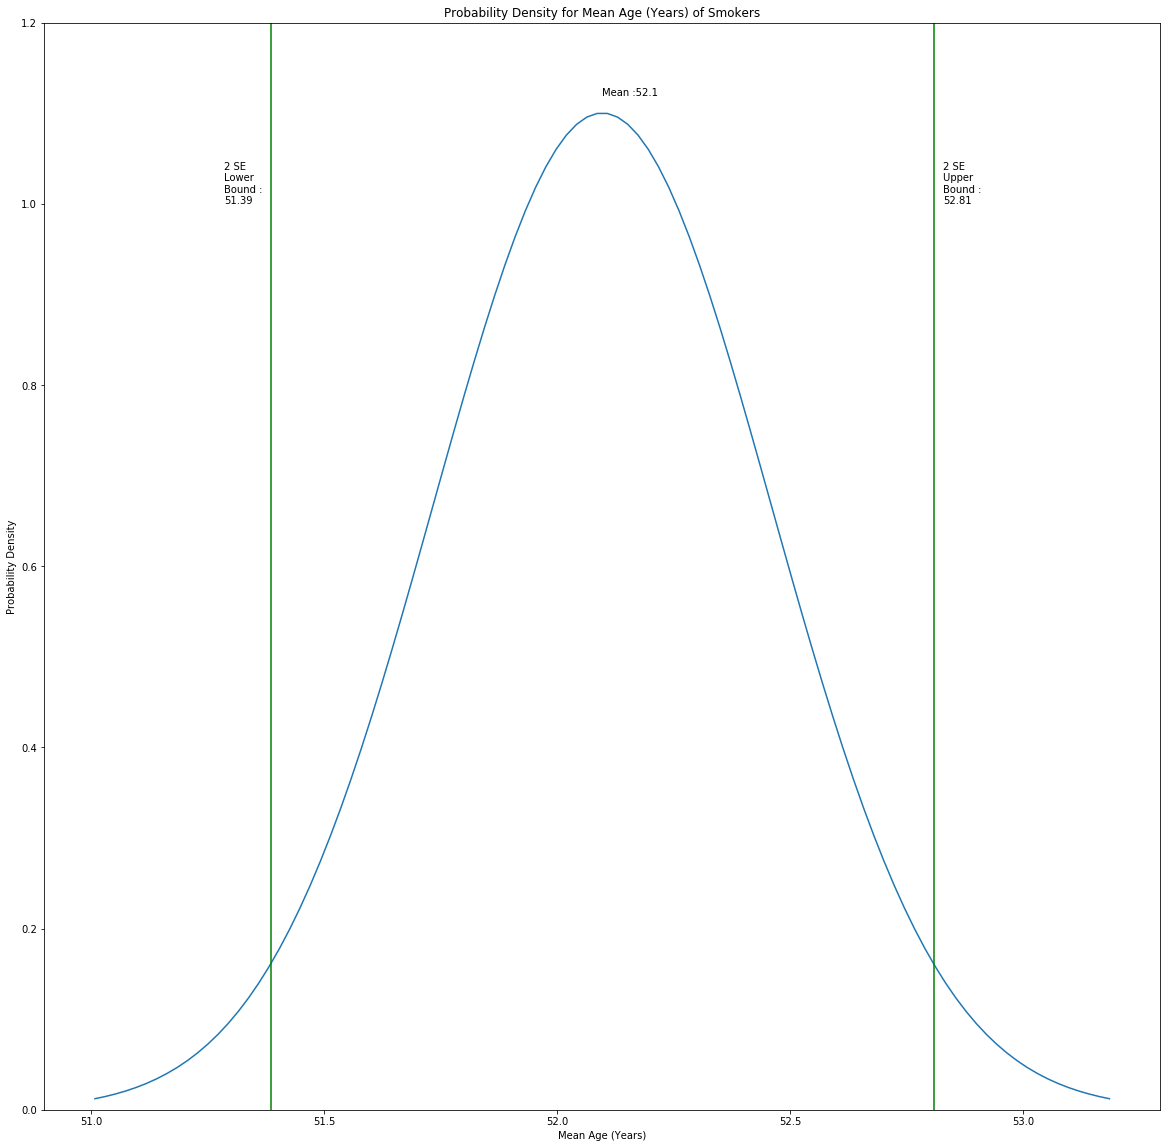

In [68]:
# variation in age of smokers
x_smok = np.linspace(age_smk_mean - 3*age_smk_se, age_smk_mean + 3*age_smk_se, 100)
plt.plot(x_smok, stats.norm.pdf(x_smok, age_smk_mean, age_smk_se))
plt.ylim([0, 1.2])

# plt.axvline(x=age_smk_mean, )
mean_text = "Mean :" + str(np.round(age_smk_mean, 2))
plt.text(age_smk_mean, 1.12, mean_text)
plt.axvline(x=age_smk_ll, color = 'green')
ll_text = "2 SE \nLower \nBound :\n" + str(np.round(age_smk_ll, 2))
plt.text(age_smk_ll-0.1, 1.0, ll_text)
plt.axvline(x=age_smk_ul, color = 'green')
ul_text = "2 SE \nUpper \nBound :\n" + str(np.round(age_smk_ul, 2))
plt.text(age_smk_ul+0.02, 1.0, ul_text)

plt.xlabel("Mean Age (Years)")
plt.ylabel("Probability Density")
plt.title("Probability Density for Mean Age (Years) of Smokers")
plt.rcParams["figure.figsize"] = (20,20)
plt.show()


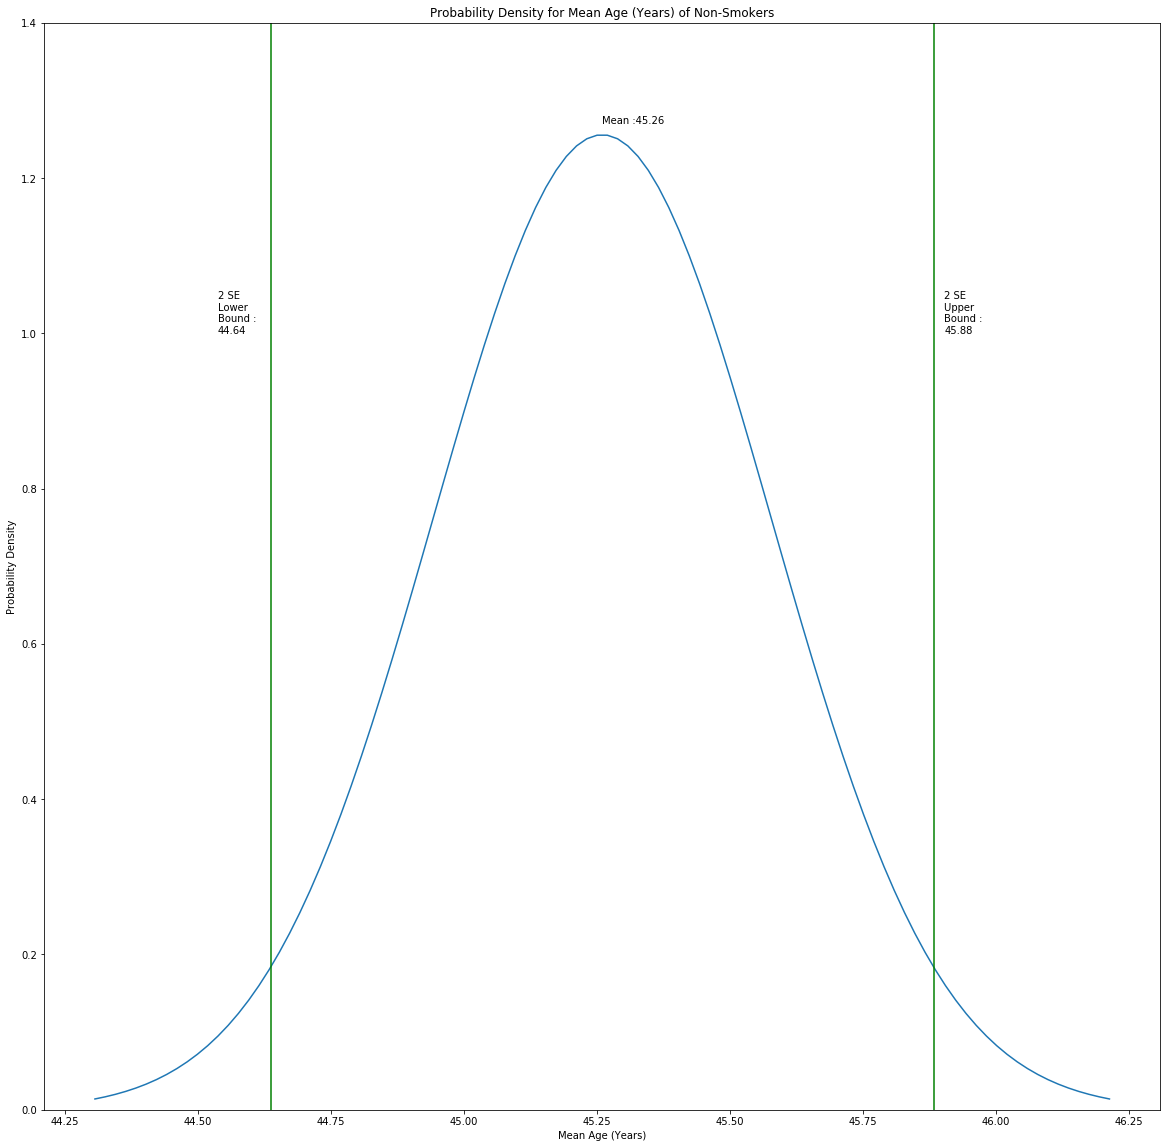

In [75]:
# variation in age of non-smokers
x_nosmok = np.linspace(age_nosmk_mean - 3*age_nosmk_se, age_nosmk_mean + 3*age_nosmk_se, 100)
plt.plot(x_nosmok, stats.norm.pdf(x_nosmok, age_nosmk_mean, age_nosmk_se))
plt.ylim([0, 1.4])

mean_text = "Mean :" + str(np.round(age_nosmk_mean, 2))
plt.text(age_nosmk_mean, 1.27, mean_text)
plt.axvline(x=age_nosmk_ll, color = 'green')
ll_text = "2 SE \nLower \nBound :\n" + str(np.round(age_nosmk_ll, 2))
plt.text(age_nosmk_ll-0.1, 1.0, ll_text)
plt.axvline(x=age_nosmk_ul, color = 'green')
ul_text = "2 SE \nUpper \nBound :\n" + str(np.round(age_nosmk_ul, 2))
plt.text(age_nosmk_ul+0.02, 1.0, ul_text)

plt.xlabel("Mean Age (Years)")
plt.ylabel("Probability Density")
plt.title("Probability Density for Mean Age (Years) of Non-Smokers")
plt.show()


__Q6b.__ Does it appear that uncertainty about the mean age of smokers, or uncertainty about the mean age of non-smokers contributed more to the uncertainty for the mean difference that we are focusing on here?

In [79]:
print("Mean age of smokers is :", age_smk_mean, "with a 95% CI of (", age_smk_mean-1.96*age_smk_se, ",", age_smk_mean+1.96*age_smk_se, ")", ", with a standard error of", age_smk_se, "from a count of", age_smk_n, "people")
print("Mean age of non-smokers is :", age_nosmk_mean, "with a 95% CI of (", age_nosmk_mean-1.96*age_nosmk_se, ",", age_nosmk_mean+1.96*age_nosmk_se, ")", ", with a standard error of", age_nosmk_se, "from a count of", age_nosmk_n, "people")


Mean age of smokers is : 52.09659335920655 with a 95% CI of ( 51.38590645243244 , 52.807280265980665 ) , with a standard error of 0.3625953605990387 from a count of 2319.0 people
Mean age of non-smokers is : 45.259835584263065 with a 95% CI of ( 44.637075954817284 , 45.882595213708846 ) , with a standard error of 0.31773450481927484 from a count of 3406.0 people
